# Data Preparation for EMNIST Letters Dataset

## Load the Dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('../emnist-letters-train.csv')

# Check the shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

2025-07-21 16:47:54.477147: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 16:47:54.487921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753087674.500429  704714 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753087674.503610  704714 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753087674.511659  704714 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Dataset shape: (64828, 785)


,24,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561
0,-2,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
1,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-2,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
4,-1,131,131,131,131,131,131,131,131,200,...,131,131,131,131,131,131,131,131,131,131


## Understanding the Data Structure

Unique labels: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]


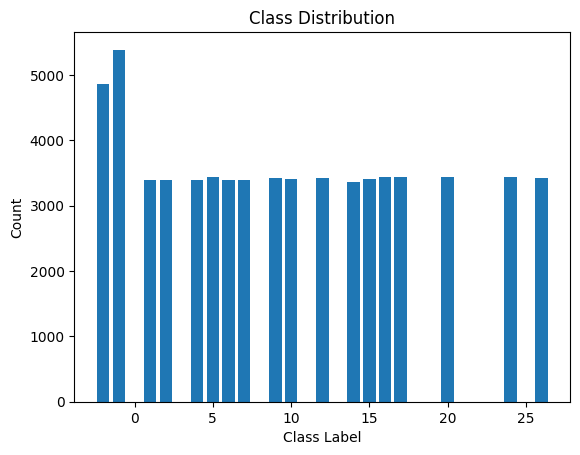

Unique labels before cleaning: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts before cleaning: [4856 5384 3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430
 3435 3436 3436 3427]
Total images before cleaning: 64828
Corresponding letters: ['>', '?', 'A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [2]:
# Separate labels and pixel data
labels = data.iloc[:, 0].values
pixels = data.iloc[:, 1:].values

# Check label distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Unique labels: {unique_labels}")

# Visualize class distribution
plt.bar(unique_labels, counts)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels before cleaning: {unique_labels}")
print(f"Label counts before cleaning: {counts}")
print(f"Total images before cleaning: {len(pixels)}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels]}")

In [3]:
# Reshape and normalize
images = pixels.reshape(-1, 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5  # Normalize to [-1, 1]

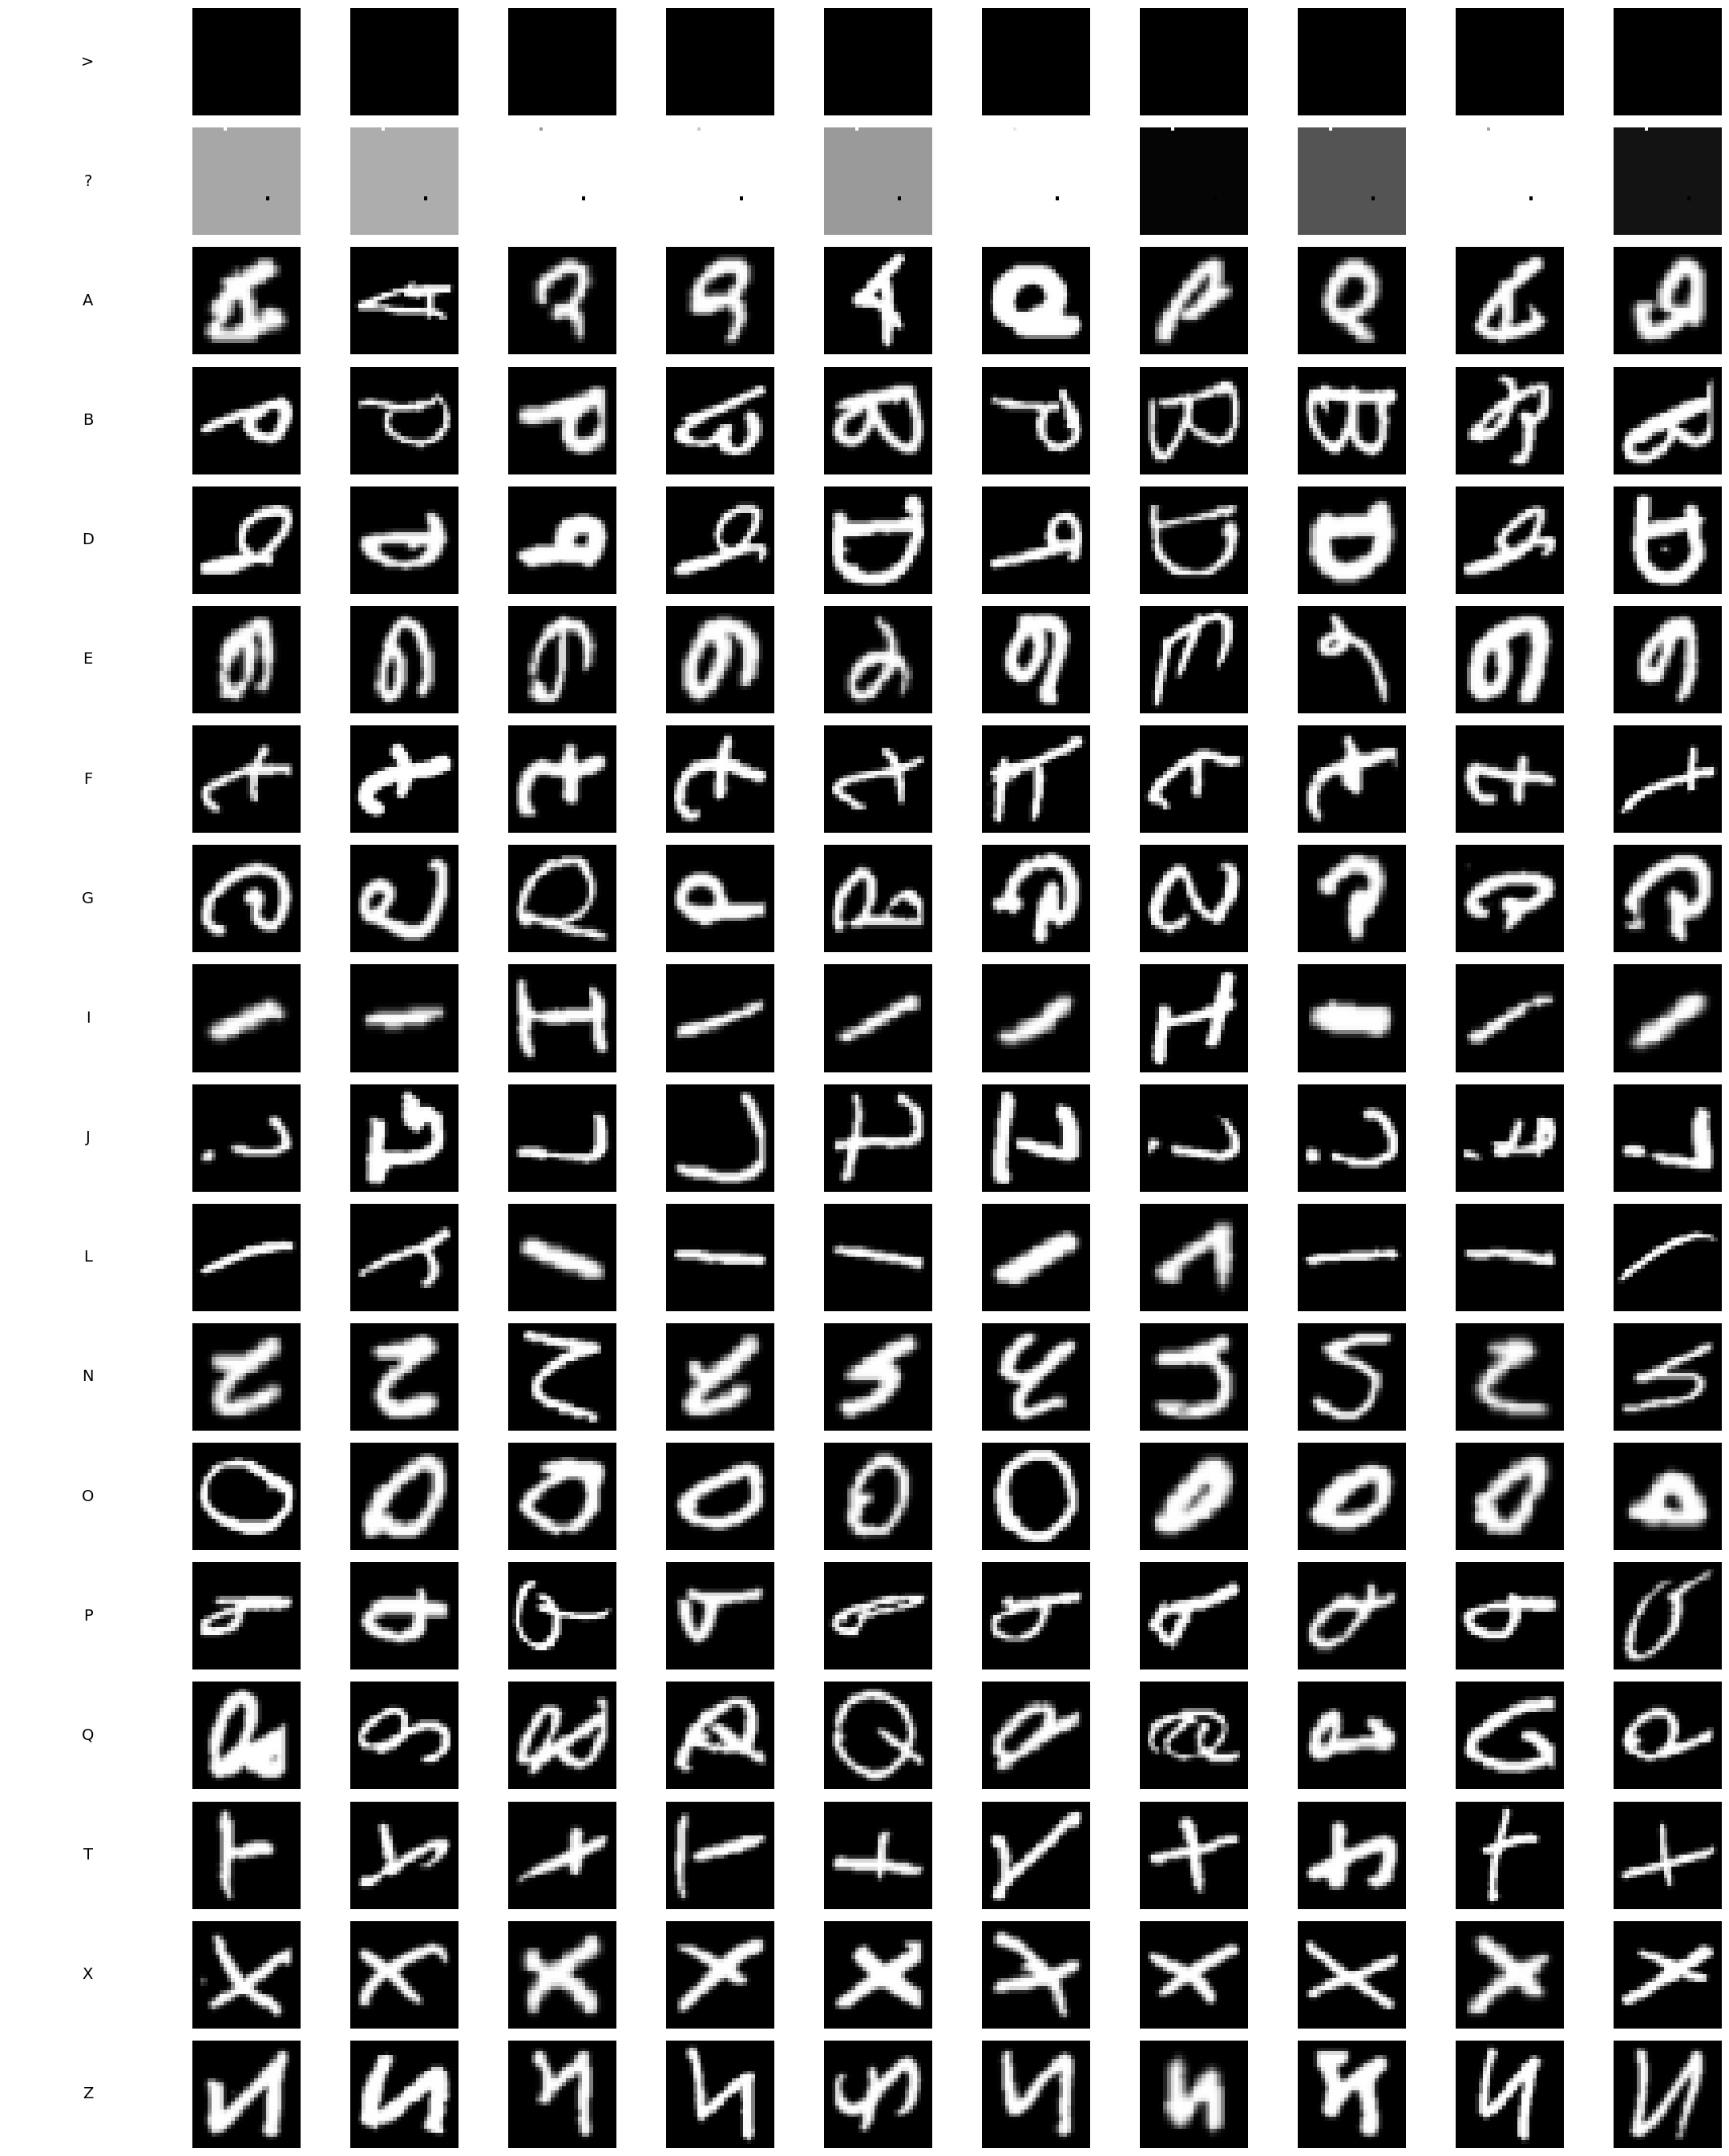

In [4]:
# Get all unique class labels
unique_labels_to_show = np.sort(np.unique(labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Data Cleaning

In [5]:
# First filter out negative labels
valid_mask = labels > 0
filtered_images = images[valid_mask]
filtered_labels = labels[valid_mask]

# Then select only our 16 target classes
selected_numeric = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]  # A, B, D, E, F, G, I, J, L, N, O, P, Q, T, X, Z
final_mask = np.isin(filtered_labels, selected_numeric)
final_images = filtered_images[final_mask]
final_labels = filtered_labels[final_mask]

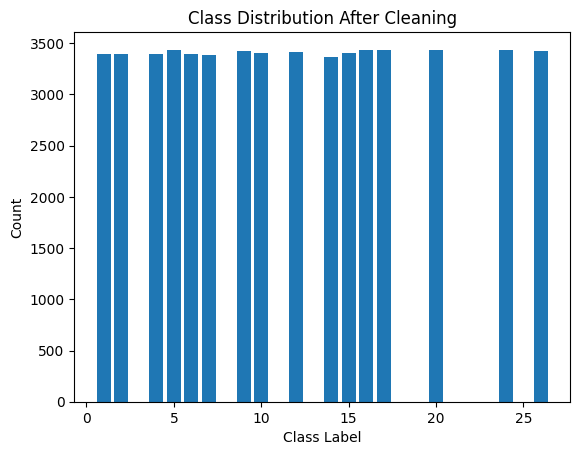

Unique labels after cleaning: [ 1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts after cleaning: [3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430 3435 3436
 3436 3427]
Total images after cleaning: 54588
Corresponding letters: ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [6]:
# Show class distribution after cleaning
unique_labels_cleaned, counts_cleaned = np.unique(final_labels, return_counts=True)
plt.bar(unique_labels_cleaned, counts_cleaned)
plt.title('Class Distribution After Cleaning')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels after cleaning: {unique_labels_cleaned}")
print(f"Label counts after cleaning: {counts_cleaned}")
print(f"Total images after cleaning: {len(final_images)}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels_cleaned]}")


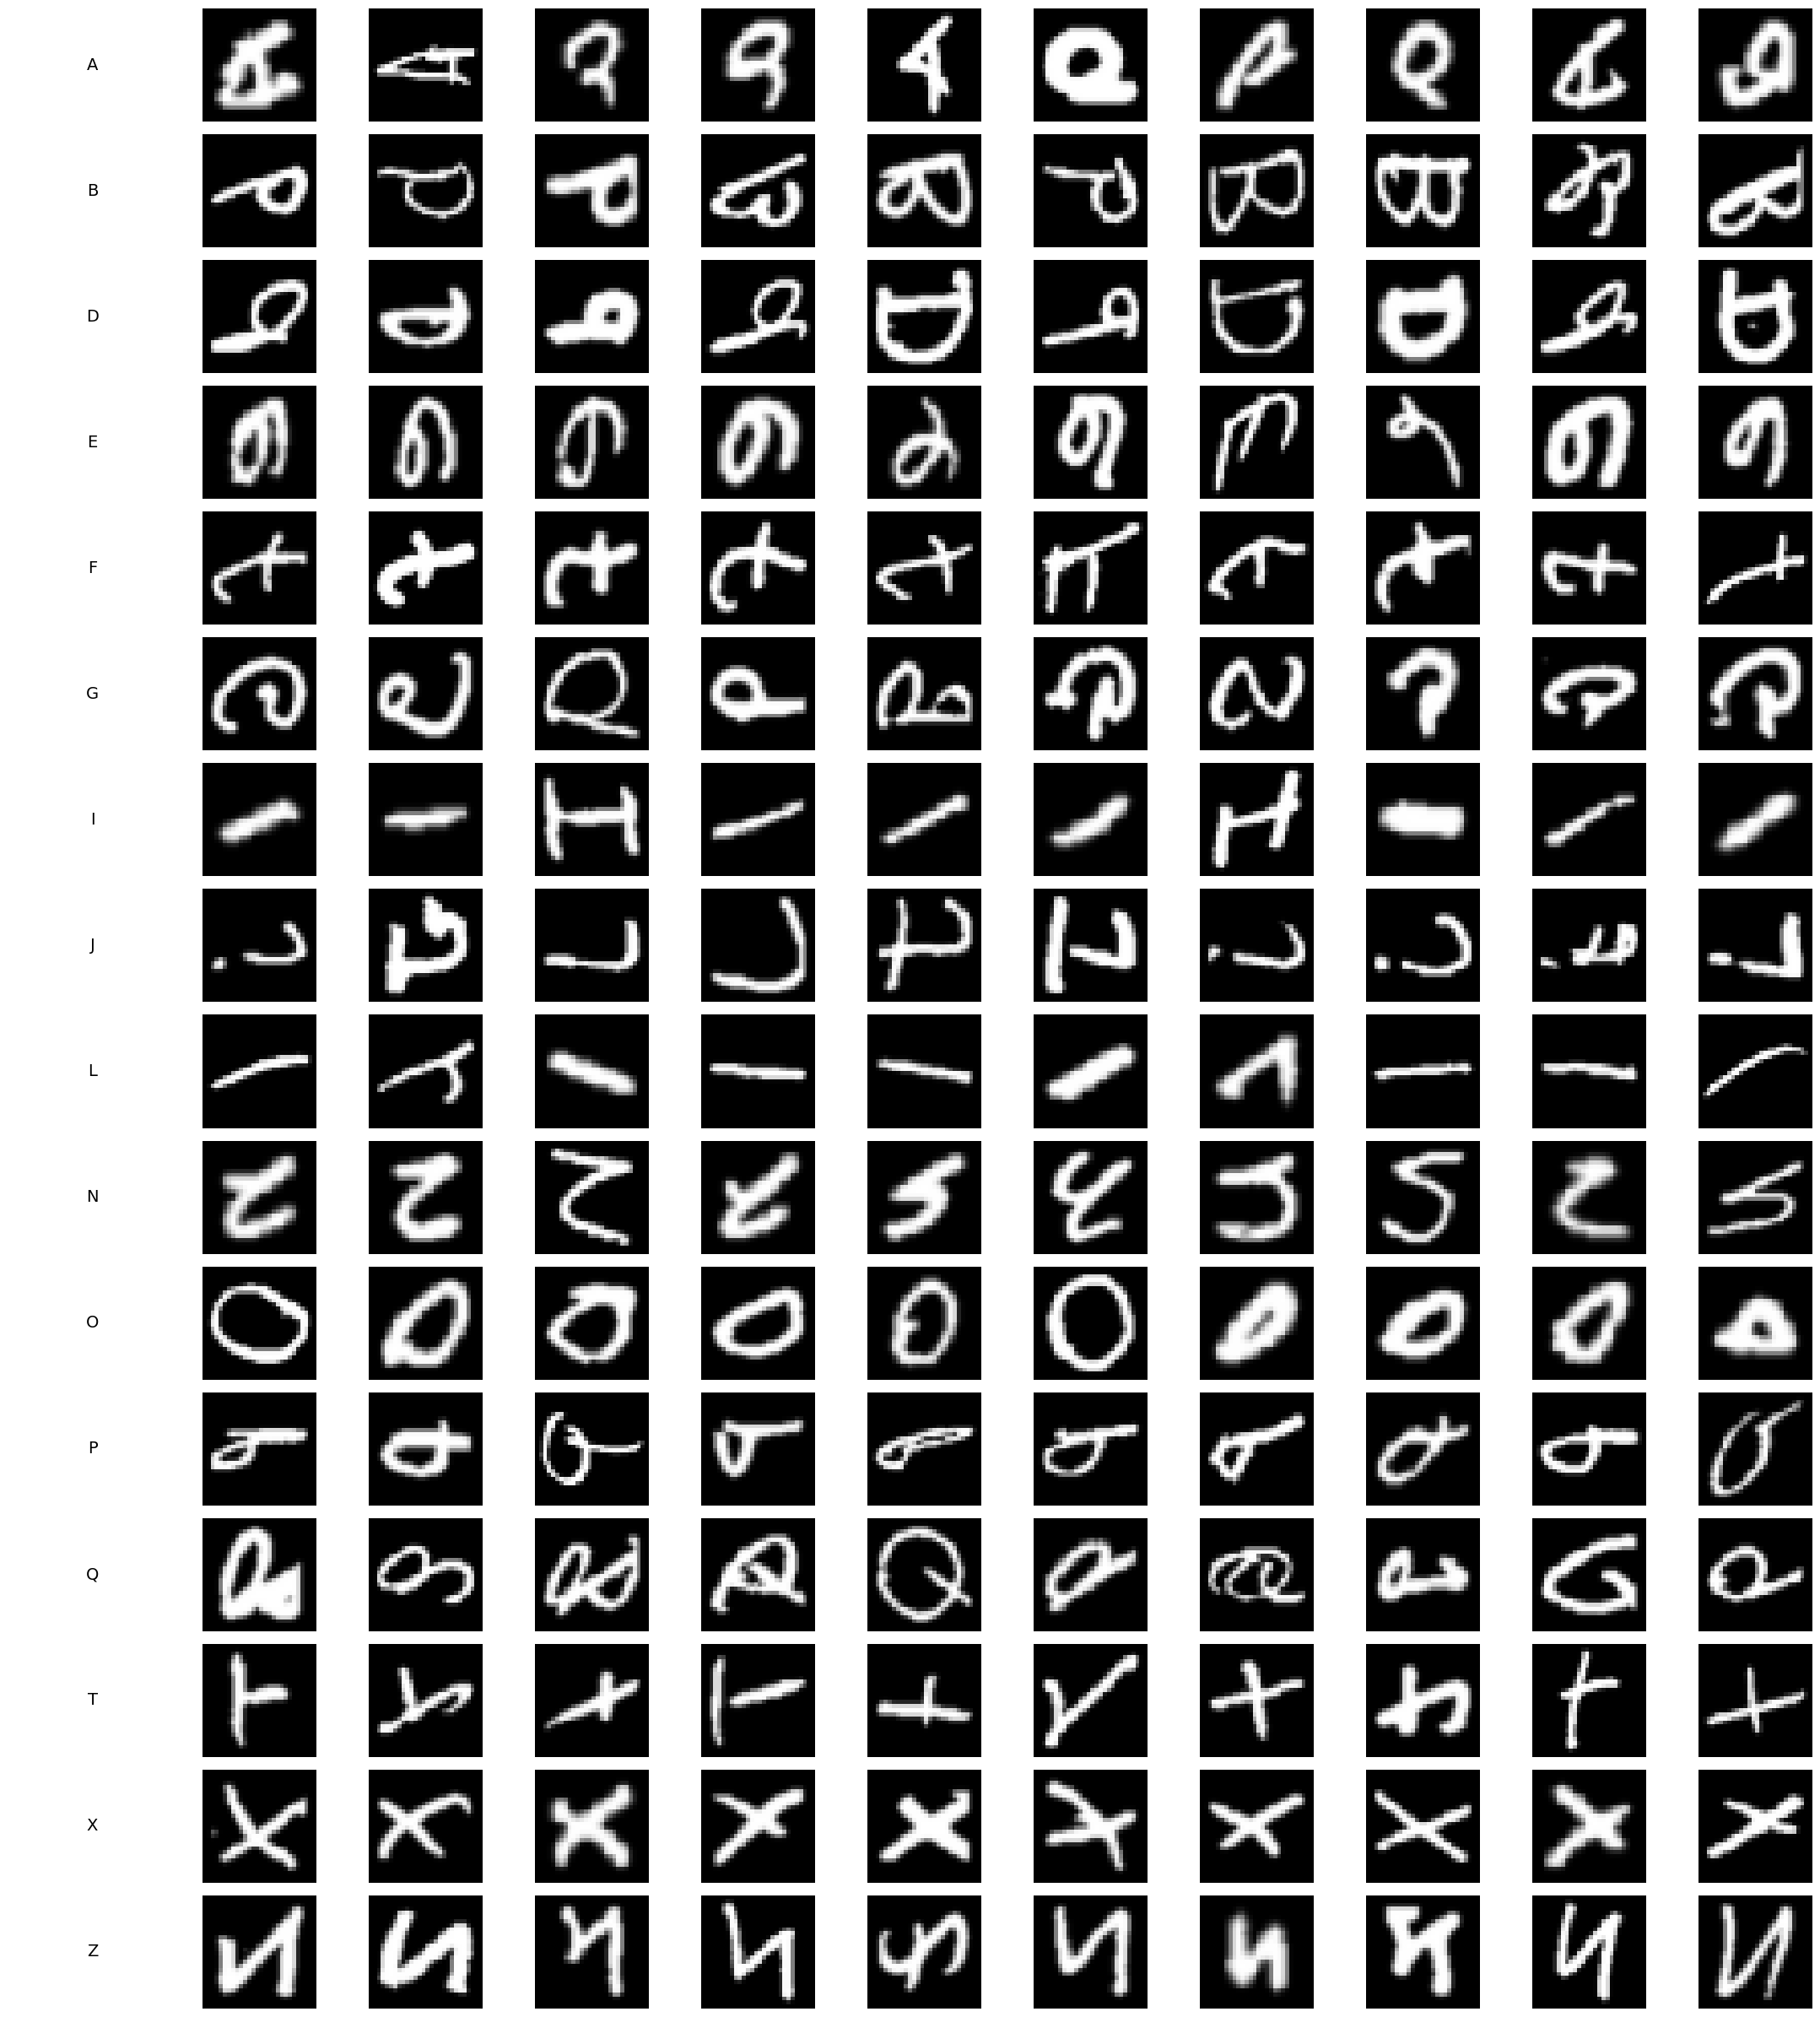

In [7]:
# Get all unique class labels from cleaned data
unique_labels_to_show = np.sort(np.unique(final_labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(final_labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(final_images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Preparing for Conditional GAN

In [8]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding (for 16 classes)
selected_letters = ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']

# Convert letters to their label values (A=1, B=2, ..., Z=26)
selected_labels = [ord(c) - 64 for c in selected_letters]

# Now convert to 0-15 range for one-hot encoding
label_mapping = {label: idx for idx, label in enumerate(selected_labels)}
mapped_labels = np.array([label_mapping[label] for label in filtered_labels])

# One-hot encode (now safe with 16 classes)
one_hot_labels = to_categorical(mapped_labels, num_classes=16)

## Data Verification 

In [9]:
# Check Basic Shapes & Types
print("Total samples:", len(final_images))
print("Image shape:", final_images.shape[1:])
print("Labels shape:", one_hot_labels.shape)
print("Image dtype:", final_images.dtype)
print("Label dtype:", one_hot_labels.dtype)


Total samples: 54588
Image shape: (28, 28, 1)
Labels shape: (54588, 16)
Image dtype: float32
Label dtype: float64


In [10]:
# Check pixel value range
print("Pixel value range:", final_images.min(), "to", final_images.max())

Pixel value range: -1.0 to 1.0


In [11]:
# Check label classes and distribution
# If labels are one-hot encoded, convert back to class indices
labels_int = np.argmax(one_hot_labels, axis=1)

print("Label classes in dataset:", np.unique(labels_int))
print("Label distribution:")
unique, counts = np.unique(labels_int, return_counts=True)
print(dict(zip(unique, counts)))


Label classes in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label distribution:
{np.int64(0): np.int64(3396), np.int64(1): np.int64(3396), np.int64(2): np.int64(3398), np.int64(3): np.int64(3437), np.int64(4): np.int64(3394), np.int64(5): np.int64(3385), np.int64(6): np.int64(3428), np.int64(7): np.int64(3402), np.int64(8): np.int64(3415), np.int64(9): np.int64(3365), np.int64(10): np.int64(3408), np.int64(11): np.int64(3430), np.int64(12): np.int64(3435), np.int64(13): np.int64(3436), np.int64(14): np.int64(3436), np.int64(15): np.int64(3427)}


## Final Dataset Preparation

In [12]:
# Create TensorFlow Dataset - CONDITIONAL GAN VERSION
# Using the filtered and properly matched data
conditional_dataset = tf.data.Dataset.from_tensor_slices((final_images, one_hot_labels))
conditional_dataset = conditional_dataset.shuffle(
    buffer_size=min(1024, len(final_images)),  # Ensure buffer isn't larger than dataset
    reshuffle_each_iteration=True
).batch(32)

# Create TensorFlow Dataset - NON-CONDITIONAL GAN VERSION
# Using just the filtered images
image_dataset = tf.data.Dataset.from_tensor_slices(final_images)
image_dataset = image_dataset.shuffle(
    buffer_size=min(1024, len(final_images)),
    reshuffle_each_iteration=True
).batch(32)

# Prefetch for better performance during training
conditional_dataset = conditional_dataset.prefetch(tf.data.AUTOTUNE)
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)  

I0000 00:00:1753087682.381240  704714 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [13]:
# Check Basic Shapes & Types for Conditional Dataset
for images, labels in conditional_dataset.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)
    print("Image dtype:", images.dtype)
    print("Label dtype:", labels.dtype)
    print("First label (one-hot):", labels[0].numpy())
    print("Pixel range (min-max):", tf.reduce_min(images).numpy(), "-", tf.reduce_max(images).numpy())


Batch images shape: (32, 28, 28, 1)
Batch labels shape: (32, 16)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'float64'>
First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Pixel range (min-max): -1.0 - 1.0


2025-07-21 16:48:03.005023: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Base Model

## Model Building

In [14]:
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

def build_generator(latent_dim=100, num_classes=16):
    # Conditional input
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    
    # Noise input
    noise_input = layers.Input(shape=(latent_dim,))
    
    # Combined input
    combined = layers.Concatenate()([noise_input, label_embedding])
    
    # Generator network
    x = layers.Dense(7*7*256, use_bias=False)(combined)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')(x)
    
    return models.Model([noise_input, label_input], x, name='generator')

def build_discriminator(img_shape=(28,28,1), num_classes=16):
    # Image input
    img_input = layers.Input(shape=img_shape)
    
    # Label input
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Dense(np.prod(img_shape))(label_embedding)
    label_embedding = layers.Reshape(img_shape)(label_embedding)
    
    # Combined input
    combined = layers.Concatenate()([img_input, label_embedding])
    
    # Discriminator network
    x = layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(combined)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model([img_input, label_input], x, name='discriminator')

# Build and compile
latent_dim = 100
img_shape = (28,28,1)
num_classes = 16

generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(img_shape, num_classes)

discriminator.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Combined GAN
discriminator.trainable = False
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,))
img = generator([noise, label])
validity = discriminator([img, label])
gan = models.Model([noise, label], validity)
gan.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy'
)

## Model Training

In [15]:
def train_gan(epochs, batch_size=128, sample_interval=50):
    # Load and normalize data
    X_train, y_train = final_images, mapped_labels  # From your data prep
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_imgs = generator.predict([noise, gen_labels.reshape(-1,1)], verbose=0)
        
        d_loss_real = discriminator.train_on_batch([imgs, labels.reshape(-1,1)], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels.reshape(-1,1)], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.random.randint(0, num_classes, batch_size)
        g_loss = gan.train_on_batch([noise, valid_labels.reshape(-1,1)], valid)
        
        # Print progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            sample_images(epoch)
    
    # Save weights
    generator.save_weights('base_generator.weights.h5')
    discriminator.save_weights('base_discriminator.weights.h5')

def sample_images(epoch):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r*c, latent_dim))
    sampled_labels = np.arange(0, num_classes).reshape(-1,1)
    
    gen_imgs = generator.predict([noise, sampled_labels])
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to 0-1
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title(f"Label: {chr(sampled_labels[cnt][0]+65)}")
            axs[i,j].axis('off')
            cnt += 1
    plt.tight_layout()
    plt.savefig(f"base_images_sample/epoch_{epoch}.png")
    plt.close()

In [16]:
# Create directory for samples
import os
os.makedirs("base_images_sample", exist_ok=True)

# Train the model
train_gan(epochs=1000, batch_size=32, sample_interval=50)

I0000 00:00:1753087683.595555  704910 service.cc:152] XLA service 0x781564003230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753087683.595615  704910 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-07-21 16:48:03.603289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753087683.623908  704910 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753087684.202191  704910 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0 [D loss: 0.7116, acc.: 41.41%] [G loss: 0.6988]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
50 [D loss: 0.7283, acc.: 11.39%] [G loss: 0.4390]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
100 [D loss: 0.7491, acc.: 10.70%] [G loss: 0.3637]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
150 [D loss: 0.7738, acc.: 10.19%] [G loss: 0.3226]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
200 [D loss: 0.8005, acc.: 10.00%] [G loss: 0.2965]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
250 [D loss: 0.8305, acc.: 9.96%] [G loss: 0.2782]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
300 [D loss: 0.8624, acc.: 9.81%] [G loss: 0.2646]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
350 [D loss: 0.8973, acc.: 9.77%] [G loss: 0.2539]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
400 [D loss: 0.9336, acc.: 9.89%] [G loss: 0.2452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
450 [D loss: 0.9674, acc.: 10.03%] [G loss: 0.2379]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
500 [D loss: 0.9969, acc.: 10.06%] [G loss: 0.2319]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
550 [D loss: 1.0